In [301]:
import pyreadr
import numpy as np
import pandas as pd
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict,RepeatedStratifiedKFold, StratifiedKFold, KFold
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, recall_score, precision_score, precision_recall_curve
from sklearn.utils import class_weight, compute_class_weight
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline, make_pipeline
import matplotlib.pyplot as plt

# <u>Preprocess Data </u>

### Import Transcript Stability Data

In [367]:
transcript_stability = pyreadr.read_r('transcript_stability_MAD_count_norm_0.8.RData')
transcript_stability = transcript_stability["transcript_stability"] # 84107 rows
transcript_stability = pd.DataFrame(transcript_stability)

### Remove transcript version from id's (*.number)

In [368]:
transcript_stability["transcript_id"] = transcript_stability["transcript_id"].str.split(".").str[0]

### Remove Housekeeping transcripts

In [369]:
h = pd.read_csv("Housekeeping_TranscriptsHuman.csv", delimiter=";")
house_genes = h["Ensembl"].values
transcript_stability = transcript_stability[~transcript_stability["transcript_id"].isin(house_genes)]

### Extract median expression & spearman stability only 

In [370]:
transcript_stability = transcript_stability.loc[:,['combined_median','stability']]

### Show dataset inbalance

NO     80544
YES     1419
Name: stability, dtype: int64


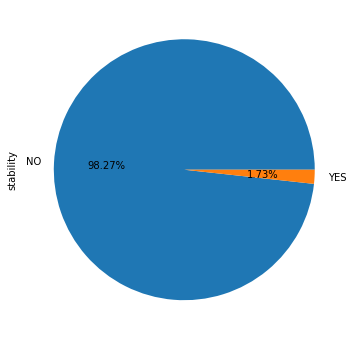

In [371]:
plt.figure(figsize=(6,6))
pd.Series(transcript_stability['stability']).value_counts().plot(kind ='pie', autopct='%1.2f%%')
print(pd.Series(transcript_stability['stability']).value_counts())

# <u>Build Random Forest classifier </u>

## 1. Basic Random Forest Classifier with k-fold cross validation

In [372]:
x1 = transcript_stability["combined_median"].values.reshape(-1, 1) # convert into 2D array
y1 = transcript_stability["stability"].values.ravel() # convert into 1D array
rf = RandomForestClassifier(n_estimators=200, random_state=42) #define classifier with n trees
k_fold = KFold(n_splits=5, random_state=42, shuffle=True) 

In [354]:
rf_scores = cross_val_score(brf, x1, y1, cv=k_fold, n_jobs=2, pre_dispatch=4)

In [355]:
print("Accuracy: %.2f%%" % (rf_scores.mean()*100.0))

Accuracy: 66.43%


### Obtain confusion matrix for predicted values

In [356]:
rf_pred = cross_val_predict(rf, x1, y1, cv=5, n_jobs=3, pre_dispatch=6) #5-fold CV
labels = np.unique(y1)
rf_conf_mat = confusion_matrix(y1, rf_pred, labels=labels)

In [357]:
pd.DataFrame(rf_conf_mat, index=labels, columns=labels)

,NO,YES
NO,77687,1855
YES,2293,128


### Plot Precision-Recall Curve

- Precision-Recall is a useful measure of success of prediction when the classes are very imbalanced.

- Precision: What proportion of positive identifications ("YES") was actually correct? If my model has a precision of 0.5—in other words, when it predicts a transcript is stable, it is correct 50% of the time.(No false positives = precision of 1.0).

- Recall: What proportion of actual positives was identified correctly (No false negatives = recall of 1.0)? If my model has a recall of 0.11—in other words, it correctly identifies 11% of all stable transcripts.


- Overall: A high AUC represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate.

#### Vary Max_Depth

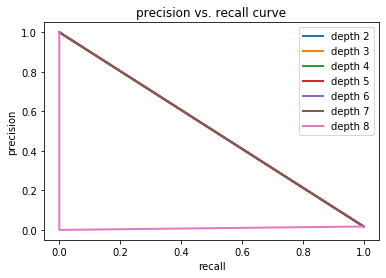

In [115]:
precision = dict()
recall = dict()

for i in range(2,9):
    rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=i)
    rf_pred = cross_val_predict(rf, x1, y1, cv=5, n_jobs=3, pre_dispatch=6)
    y2 = np.where(y1 =="YES", True, False)
    rf_pred2 = np.where(rf_pred =="YES", True, False)
    precision[i], recall[i], _ = precision_recall_curve(y2, rf_pred2)
    plt.plot(recall[i], precision[i], lw=2, label='depth {}'.format(i))

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

#### Vary n_trees with max_depth of 2 

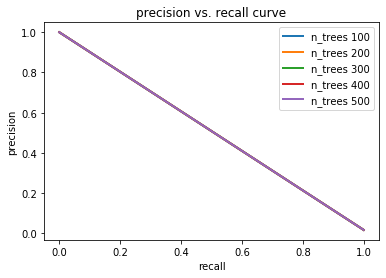

In [117]:
precision = dict()
recall = dict()
trees = [100,200,300,400,500]
for i in trees:
    rf = RandomForestClassifier(n_estimators=i, random_state=42, max_depth=2)
    rf_pred = cross_val_predict(rf, x1, y1, cv=5, n_jobs=3, pre_dispatch=6)
    y2 = np.where(y1 =="YES", True, False)
    rf_pred2 = np.where(rf_pred =="YES", True, False)
    precision[i], recall[i], _ = precision_recall_curve(y2, rf_pred2)
    plt.plot(recall[i], precision[i], lw=2, label='n_trees {}'.format(i))

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

#### Table of performance (Precision, Recall, F-score) with varying N-trees, 10-fold CV

In [15]:
precision = []
recall = []
f1 = []

trees = [50,100,200,300]
for i in trees:
    rf = RandomForestClassifier(n_estimators=i, random_state=42)
    rf_pred = cross_val_predict(rf, x1, y1, cv=10, n_jobs=3, pre_dispatch=6)
    f1_s = f1_score(y1, rf_pred, pos_label="YES")
    recall_s = recall_score(y1, rf_pred, pos_label="YES")
    precision_s = precision_score(y1, rf_pred, pos_label="YES")
    f1.append(f1_s)
    recall.append(recall_s)
    precision.append(precision_s)

In [16]:
data = {'Precision':precision, 'Recall':recall, "F1":f1}

In [17]:
rf_table = pd.DataFrame(data)
rf_table.index = ['50', '100', '200', '300']
rf_table

,Precision,Recall,F1
50,0.056780,0.047216,0.051558
100,0.054455,0.046512,0.050171
200,0.054276,0.046512,0.050095
300,0.054276,0.046512,0.050095
400,0.054276,0.046512,0.050095


## 2. Balanced Random Forest Classifier with k-fold cross validation

- Will downsample majority class (unstable transcripts)
- For each tree in RF, down-sample the majority class to the same size as the minority class
- Given enough trees, all training data are used, so no loss of information
- Computationally efficient, since each tree only sees a small sample


In [378]:
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=42, max_depth=2) #1,3
k_fold = KFold(n_splits=10, random_state=42, shuffle=True)
sk_fold = StratifiedKFold(n_splits=10, random_state=42, shuffle=True) #stratified better for unbalanced datasets

In [381]:
brf_scores = cross_val_score(brf, x1, y1, cv=sk_fold, n_jobs=2, pre_dispatch=4)

In [382]:
print("Accuracy: %.2f%%" % (brf_scores.mean()*100.0))

Accuracy: 67.57%


### Obtain confusion matrix for predicted values

In [379]:
brf_pred = cross_val_predict(brf, x1, y1, cv=sk_fold, n_jobs=3, pre_dispatch=6)
labels = np.unique(y1)
conf_mat = confusion_matrix(y1, brf_pred, labels=labels)

In [380]:
pd.DataFrame(conf_mat, index=labels, columns=labels)

,NO,YES
NO,54309,26235
YES,345,1074


#### Vary Max_Depth

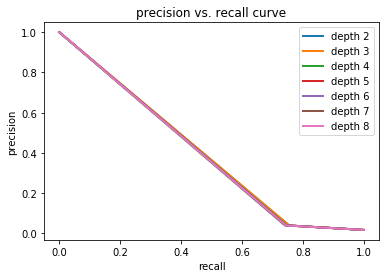

In [22]:
precision = dict()
recall = dict()
k_fold = KFold(n_splits=10, random_state=42, shuffle=True)
for i in range(2,9):
    brf = BalancedRandomForestClassifier(n_estimators=100, random_state=42, max_depth=i)
    brf_pred = cross_val_predict(brf, x1, y1, cv=k_fold, n_jobs=3, pre_dispatch=6)
    y2 = np.where(y1 =="YES", True, False)
    brf_pred2 = np.where(brf_pred =="YES", True, False)
    precision[i], recall[i], _ = precision_recall_curve(y2, brf_pred2)
    plt.plot(recall[i], precision[i], lw=2, label='depth {}'.format(i))

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

#### Vary n_trees with max_depth of 2

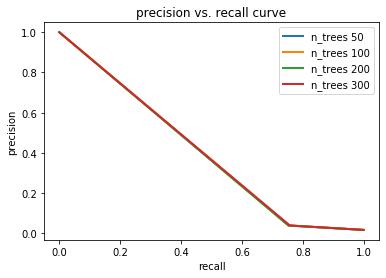

In [23]:
precision = dict()
recall = dict()
trees = [50,100,200,300]
for i in trees:
    brf = BalancedRandomForestClassifier(n_estimators=i, random_state=42, max_depth=2)
    brf_pred = cross_val_predict(brf, x1, y1, cv=k_fold, n_jobs=3, pre_dispatch=6)
    y2 = np.where(y1 =="YES", True, False)
    brf_pred2 = np.where(brf_pred =="YES", True, False)
    precision[i], recall[i], _ = precision_recall_curve(y2, brf_pred2)
    plt.plot(recall[i], precision[i], lw=2, label='n_trees {}'.format(i))

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

#### Table of performance (Precision, Recall, F-score) with varying N-trees (k-fold CV)

In [28]:
precision = []
recall = []
f1 = []

trees = [50,100,200,300,400,500]
for i in trees:
    brf = BalancedRandomForestClassifier(n_estimators=i, random_state=42)
    brf_pred = cross_val_predict(brf, x1, y1, cv=k_fold, n_jobs=3, pre_dispatch=6)
    f1_s = f1_score(y1, brf_pred, pos_label="YES")
    recall_s = recall_score(y1, brf_pred, pos_label="YES")
    precision_s = precision_score(y1, brf_pred, pos_label="YES")
    f1.append(f1_s)
    recall.append(recall_s)
    precision.append(precision_s)

In [29]:
data = {'Precision':precision, 'Recall':recall, "F1":f1}

In [30]:
brf_table = pd.DataFrame(data)
brf_table.index = ['50', '100', '200', '300', '400','500']
brf_table

,Precision,Recall,F1
50,0.037552,0.690627,0.071231
100,0.036913,0.689922,0.070076
200,0.036924,0.692741,0.070112
300,0.037175,0.697674,0.070588
400,0.037112,0.697674,0.070475
500,0.036982,0.696970,0.070236


#### Table of performance (Precision, Recall, F-score) with varying N-trees (stratified k-fold CV)

In [390]:
precision = []
recall = []
f1 = []

trees = [50,100,200,300, 400, 500, 1000]
for i in trees:
    brf = BalancedRandomForestClassifier(n_estimators=i, random_state=42, max_depth=2)
    brf_pred = cross_val_predict(brf, x1, y1, cv=sk_fold, n_jobs=3, pre_dispatch=6)
    f1_s = f1_score(y1, brf_pred, pos_label="YES")
    recall_s = recall_score(y1, brf_pred, pos_label="YES")
    precision_s = precision_score(y1, brf_pred, pos_label="YES")
    f1.append(f1_s)
    recall.append(recall_s)
    precision.append(precision_s)

In [391]:
data = {'Precision':precision, 'Recall':recall, "F1":f1}

In [392]:
brf_table = pd.DataFrame(data)
brf_table.index = ['50', '100', '200', '300','400', '500', '1000']
brf_table

,Precision,Recall,F1
50,0.039267,0.754052,0.074648
100,0.039328,0.756871,0.074770
200,0.039166,0.756166,0.074475
300,0.039259,0.759690,0.074659
400,0.039236,0.760395,0.074622
500,0.039269,0.760395,0.074682
1000,0.039257,0.759690,0.074656


In [386]:
tn, fp, fn, tp = confusion_matrix(y1, brf_pred).ravel()
print(f'TN: ',tn)
print(f'FN: ',fn)
print(f'TP: ',tp)
print(f'FP: ',fp)

TN:  54221
FN:  346
TP:  1073
FP:  26323


## 2. Weighted Random Forest Classifier with k-fold cross validation

- Place a heavier penalty on misclassifying the minority class (stable transcripts), using class_weight
- Ex: {"NO":1, "YES":50} = every sample from class "YES" would count as 50 samples from class "NO", therefore giving more "importance" to your elements from class "YES" (as you have less of those samples surely)

### Calculate class weights

In [222]:
c1 = np.ones(1419)
c2 = np.ones(80544) + 1
c3 = np.concatenate([c1, c2])

classes=[1,2]
cw = compute_class_weight('balanced', classes, c3)

/Users/anthmam/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[1, 2], y=[1. 1. 1. ... 2. 2. 2.] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [234]:
len(c3)

81963

In [225]:
cw/2.11

array([13.6874643 ,  0.24114163])

In [306]:
wrf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight={"NO":1, "YES":100})
wrf_pred = cross_val_predict(wrf, x1, y1, cv=sk_fold, n_jobs=3, pre_dispatch=6)

### Obtain confusion matrix for predicted values

In [307]:
accuracy = accuracy_score(y1, wrf_pred)
labels = np.unique(y1)
conf_wrf = confusion_matrix(y1, wrf_pred, labels=labels) #extract confusion matrix

In [308]:
print(accuracy * 100)

95.9457316106048


In [309]:
pd.DataFrame(conf_wrf, index=labels, columns=labels)

,NO,YES
NO,78544,2000
YES,1323,96


#### Vary Class_Weight

In [ ]:
precision = []
recall = []
f1 = []

weight = []

for i in weight:
    wrf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight={"NO": 1, "YES": i})
    wrf_pred = cross_val_predict(wrf, x1, y1, cv=sk_fold, n_jobs=3, pre_dispatch=6)
    f1_s = f1_score(y1, wrf_pred, pos_label="YES")
    recall_s = recall_score(y1, wrf_pred, pos_label="YES")
    precision_s = precision_score(y1, wrf_pred, pos_label="YES")
    f1.append(f1_s)
    recall.append(recall_s)
    precision.append(precision_s)

## 3. SMOTE with k-fold cross validation

- Specialized over-sampling of minority class ("YES")

In [255]:
kf = KFold(n_splits=10)

for fold, (train_index, test_index) in enumerate(kf.split(x1), 1):
    X_train = x1[train_index]
    y_train = y1[train_index]  # Based on your code, you might need a ravel call here, but I would look into how you're generating your y
    X_test = x1[test_index]
    y_test = y1[test_index]  # See comment on ravel and  y_train
    sm = SMOTE()
    X_train_oversampled, y_train_oversampled = sm.fit_sample(X_train, y_train)
    model = RandomForestClassifier(n_estimators=100)  # Choose a model here
    model.fit(X_train_oversampled, y_train_oversampled )  
    y_pred = model.predict(X_test)
    print(f'For fold {fold}:')
    print(f'Accuracy: {model.score(X_test, y_test)}')
    print(f'f-score: {f1_score(y_test, y_pred, pos_label="YES")}')
    print(f'recall-score: {recall_score(y_test, model.predict(X_test), pos_label="YES")}')

For fold 1:
Accuracy: 0.7207514944491887
f-score: 0.06380368098159508
recall-score: 0.624
For fold 2:
Accuracy: 0.7339270464804196
f-score: 0.060318828091339934
recall-score: 0.4666666666666667
For fold 3:
Accuracy: 0.7675979016713431
f-score: 0.061113849186791525
recall-score: 0.4397163120567376
For fold 4:
Accuracy: 0.7907515861395803
f-score: 0.08825093035619351
recall-score: 0.5220125786163522
For fold 5:
Accuracy: 0.740971205466081
f-score: 0.04326273095989184
recall-score: 0.5274725274725275
For fold 6:
Accuracy: 0.7941678867740362
f-score: 0.052779337450870295
recall-score: 0.373015873015873
For fold 7:
Accuracy: 0.7875793069790141
f-score: 0.07442849548112705
recall-score: 0.4430379746835443
For fold 8:
Accuracy: 0.7961200585651538
f-score: 0.06386554621848739
recall-score: 0.38
For fold 9:
Accuracy: 0.7508540751586139
f-score: 0.06587374199451053
recall-score: 0.4864864864864865
For fold 10:
Accuracy: 0.7817227916056613
f-score: 0.07353702744691869
recall-score: 0.415204678362

In [401]:
kf_2 = KFold(n_splits=10, shuffle=True)
imba_pipeline = make_pipeline(SMOTE(random_state=42), 
                              RandomForestClassifier(n_estimators=200, random_state=13, max_depth=2))

In [394]:
smote_score = cross_val_score(imba_pipeline, x1, y1, cv=kf_2)

In [396]:
print("Accuracy: %.2f%%" % (smote_score.mean()*100.0))

Accuracy: 67.91%


In [402]:
smote_score_pred = cross_val_predict(imba_pipeline, x1, y1, cv=kf_2, n_jobs=3, pre_dispatch=6)

In [403]:
accuracy = accuracy_score(y1, smote_score_pred)
labels = np.unique(y1)
smote_mat = confusion_matrix(y1, smote_score_pred, labels=labels)
pd.DataFrame(smote_mat, index=labels, columns=labels)

,NO,YES
NO,54379,26165
YES,350,1069


#### Vary Max_Depth

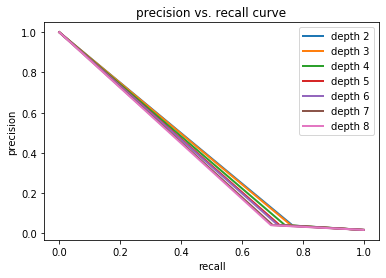

In [270]:
precision = dict()
recall = dict()

p = []
r = []
f = []
kf_2 = KFold(n_splits=5, shuffle=False)

for i in range(2,9):
    imba_pipeline = make_pipeline(SMOTE(random_state=42), 
                              RandomForestClassifier(n_estimators=100, random_state=13, max_depth=i))
    smote_score_pred = cross_val_predict(imba_pipeline, x1, y1, cv=kf_2, n_jobs=3, pre_dispatch=6)
    y2 = np.where(y1 =="YES", True, False)
    smote_score_pred2 = np.where(smote_score_pred =="YES", True, False)
    
    f1_s = f1_score(y1, smote_score_pred, pos_label="YES")
    recall_s = recall_score(y1, smote_score_pred, pos_label="YES")
    precision_s = precision_score(y1, smote_score_pred, pos_label="YES")
    f.append(f1_s)
    r.append(recall_s)
    p.append(precision_s)
    
    precision[i], recall[i], _ = precision_recall_curve(y2, smote_score_pred2)
    plt.plot(recall[i], precision[i], lw=2, label='depth {}'.format(i))

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

In [271]:
data = {'Precision':p, 'Recall':r, "F1":f}

In [272]:
smote_table = pd.DataFrame(data)
smote_table.index = ['2', '3', '4', '5', '6','7','8']
smote_table

,Precision,Recall,F1
2,0.039202,0.766737,0.074590
3,0.039149,0.762509,0.074474
4,0.041097,0.741367,0.077877
5,0.041353,0.723749,0.078236
6,0.041356,0.718111,0.078207
7,0.041352,0.701198,0.078097
8,0.040666,0.695560,0.076839


## 4. Gradient Boosting with k-fold cross validation

In [296]:
grf = GradientBoostingClassifier(random_state=42)
sk_fold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True) #stratified better for unbalanced datasets

In [297]:
grf_pred = cross_val_predict(grf, x1, y1, cv=sk_fold, n_jobs=3, pre_dispatch=6)

In [298]:
labels = np.unique(y1)
grf_mat = confusion_matrix(y1, grf_pred, labels=labels)
pd.DataFrame(grf_mat, index=labels, columns=labels)

,NO,YES
NO,80469,75
YES,1418,1


## 5. Logistic Regression with k-fold cross validation